In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker


import numpy as np
import time
# from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import loadmat,savemat




#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device1 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print("Device 1: ",device1)
print("Device 2: ",device2)

Device 1:  cuda:2
Device 2:  cuda:3


In [2]:
#1ms = 10^-2 ds
R0 = 5.36 #mm 5.36
Rs = 19 #mm
mu_vis = 0.3 
mu = 0.3 #Friction Coefficient (not viscosity)
delta = 0.5
A = 6.41 #For slip factor
pi = np.pi

Omega = 300 #rpm
V = 2 #mm/s
F = 0.67 #mm/s

rho = 2700 * 1e-6 #g/mm3
k = 167 *1e-3 #Thermal Conductivity #g.mm/((ms)^3.K)
c_p = 897 # mm^2/ms^2.K #Wrong mJ/gK 
alpha_m = k/(rho*c_p)


k_B = 1.380649*1e-23 #J/K
R = 8.314 #J/(K.mol)
E_a = 205000 #J/mol #Q

alpha_sig =  52 #mm^2.(ms^2)/(kg.mm) #52 is wrong in correct units of g, mm, ms

# A = np.exp(27.78)
log_A = 27.78 - 6.9078 # Units in ms-1
n = 3.49
T_a = 298.0


k_t = 17.6 *1e-3 #gmm/(ms^3.K)
c_p_t = 460 # mm^2/ms^2.K
rho_t = 7750 * 1e-6 #g/mm3
alpha_t = k_t/(rho_t*c_p_t)

h_sides = 5*1e-6 #Wrong W/mm^2K #Corrected g/ms^3.K 
C_bot = 0.15*1e-6 #W/mm^2K^3 #corrected g/ms^3.K^3

eeta = alpha_m/(alpha_m+alpha_t)

lb_xyz_uvw = np.array([-50.0,-20.0,-3.0])
ub_xyz_uvw = np.array([50.0,20.0,0.0])


lb_xyz = np.array([-50.0,-20.0,-3.0])
ub_xyz = np.array([50.0,20.0,0.0])



In [3]:
def train_step(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat,uvw_true_top,r_fr_ph_out):
    # def closure():
    optimizer.zero_grad()
    #model_PINN.zero_grad()
    loss_uvw,loss_T = model_PINN.loss(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat,uvw_true_top,r_fr_ph_out)
    loss_uvw.backward()
    loss_T.backward()

        # return loss

    optimizer.step()

In [4]:
def train_model(max_iter,rep,n_batches):
    print(rep)
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0

    xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot, uvw_true_top,r_fr_ph_out = trainingdata_uvw(N_B,N_f,lb_xyz,ub_xyz,rep*123)
    xyz_coll = torch.from_numpy(xyz_coll).float()#.to(device)
    xyz_1 = torch.from_numpy(xyz_1).float()#.to(device)
    xyz_2 = torch.from_numpy(xyz_2).float()#.to(device)
    xyz_3 = torch.from_numpy(xyz_3).float()#.to(device)
    xyz_4 = torch.from_numpy(xyz_4).float()#.to(device)
    r_fr_ph_out = torch.from_numpy(r_fr_ph_out).float()
    
    xyz_top = torch.from_numpy(xyz_top).float()#.to(device)
    xyz_bot = torch.from_numpy(xyz_bot).float()#.to(device)
   
    uvw_true_top = torch.from_numpy(uvw_true_top).float().to(device1)
    f_hat = torch.zeros(xyz_coll.shape[0],1)#.to(device1)
    N_hat = torch.zeros(xyz_top.shape[0],1).to(device2)
    

    #pretrain
    # for i in range(50):
    #     optimizer.zero_grad()
    #     loss_pretrain = model_PINN.pretrain_T_loss(xyz_coll)
    #     loss_pretrain.backward()
    #     optimizer.step()
        
    # print("Pretrained with T = 300.0")
    
    #Batching only Collocation and f_hat for now
    
    # batch_size_coll = int(xyz_coll.shape[0]/n_batches)
    # batch_size_top = int(xyz_top.shape[0]/n_batches)

    # batch_size_sides = int(xyz_1.shape[0]/n_batches)
    # batch_size_bot = int(xyz_bot.shape[0]/n_batches)

    # xyz_coll_batches = torch.split(xyz_coll,batch_size_coll)
    # f_hat_batches = torch.split(f_hat,batch_size_coll)
    
    # xyz_top_batches = torch.split(xyz_top,batch_size_top)
    # N_hat_batches = torch.split(N_hat,batch_size_top)

    # xyz_1_batches = torch.split(xyz_1,batch_size_sides)
    # xyz_2_batches = torch.split(xyz_2,batch_size_sides)
    # xyz_3_batches = torch.split(xyz_3,batch_size_sides)
    # xyz_4_batches = torch.split(xyz_4,batch_size_sides)
    
    # xyz_bot_batches = torch.split(xyz_4,batch_size_bot)

    # uvw_true_top_batches = torch.split(uvw_true_top,batch_size_top)
    # r_fr_ph_out_batches = torch.split(r_fr_ph_out,batch_size_top)
    


    
    for i in range(max_iter):
#         if(i>0 and i%50==0):
#             _,_,_,_,_,xyz_top,xyz_bot = trainingdata(N_B,N_f,i*123)
#             # xyz_coll = torch.from_numpy(xyz_coll).float().to(device)
#             # xyz_1 = torch.from_numpy(xyz_1).float().to(device)
#             # xyz_2 = torch.from_numpy(xyz_2).float().to(device)
#             # xyz_3 = torch.from_numpy(xyz_3).float().to(device)
#             # xyz_4 = torch.from_numpy(xyz_4).float().to(device)

#             xyz_top = torch.from_numpy(xyz_top).float().to(device)
#             xyz_bot = torch.from_numpy(xyz_bot).float().to(device)

        # optimizer.zero_grad()
        # for b in range(n_batches):
        #     loss_uvw,loss_T = model_PINN.loss(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat,uvw_true_top,r_fr_ph_out)
        #     loss_uvw.backward()
        #     loss_T.backward()

        # optimizer.step()
        
        # train_step(xyz_coll_batches[b],xyz_1_batches[b], xyz_2_batches[b], xyz_3_batches[b], xyz_4_batches[b],xyz_top_batches[b],xyz_bot_batches[b],f_hat_batches[b],N_hat_batches[b],uvw_true_top_batches[b],r_fr_ph_out_batches[b])
            

        train_step(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat,uvw_true_top,r_fr_ph_out)
        # loss_np = PINN.loss(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat).cpu().detach().numpy()
        # print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        loss_np1,loss_np2 = model_PINN.loss(xyz_coll,xyz_1, xyz_2, xyz_3, xyz_4,xyz_top,xyz_bot,f_hat,N_hat,uvw_true_top,r_fr_ph_out)
        print(i,"Train Loss",loss_np1.cpu().detach().numpy() + loss_np2.cpu().detach().numpy())

        # if(i>0 and i%25 ==0):
        #   pretrain(xyt_DBC,p_iters)


    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [5]:
# from Seq_model import Sequentialmodel
from Seq_Model_Parallel import coupled_PINN
from training_samples import trainingdata_uvw,trainingdata_T

label = 'meltpool'
max_reps = 1
max_iter = 10000
p_iters = 10

N_B = 1000
N_f = 10000
n_batches = 5

train_loss_full = []
test_mse_full = []
test_re_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

for reps in range(max_reps):

    train_loss = []
    test_mse_loss = []
    test_re_loss = []

    'Generate Training data'
    torch.manual_seed(reps*3)
     #Total number of collocation points


    layers1 = np.array([3,50,50,50,4]) #9 hidden layers
    layers2 = np.array([3,50,50,50,1]) #9 hidden layers
    # layers = np.array([3,50,50,50,5])
    # layers = np.array([3,64,64,64,1])
    model_PINN = coupled_PINN(layers1,layers2,device1,device2,lb_xyz,ub_xyz)
    # PINN = nn.DataParallel(PINN)
    #PINN.to(device)

    'Neural Network Summary'
    #print(PINN)

    #params = list(PINN.parameters())

    # optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25,
    #                           max_iter = 30,
    #                           max_eval = 50,
    #                           tolerance_grad = 1e-5,
    #                           tolerance_change = 1e-5,
    #                           history_size = 100,
    #                           line_search_fn = 'strong_wolfe')

    optimizer = torch.optim.Adam(model_PINN.parameters(),lr=0.01, betas=(0.9, 0.999))

    start_time = time.time()
    train_model(max_iter,reps,n_batches)


    torch.save(model_PINN.state_dict(),'./Models_Trained/AFSD_Exp_'+str(Omega)+'rpm_'+str(V)+ 'mms.pt')
    # train_loss_full.append(train_loss)
    # test_mse_full.append(test_mse_loss)
    # test_re_full.append(test_re_loss)


    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full, "test_re_loss": test_re_full, "Time": elapsed_time, "label": label, "Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=4, bias=True)
  )
)
Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
tensor(15.2564)
tensor(15.2564)
tensor(15.3023)
tensor(15.4603)
tensor(15.4603)
tensor(15.4404)
0 Train Loss 6822.352
tensor(15.4603)
tensor(15.4603)
tensor(15.4404)
tensor(15.5680)
tensor(15.5680)
tensor(15.5540)
1 Train Loss 5876.301
tensor(15.5680)
tensor(15.5680)
tensor(15.5540)
tensor(15.6307)
tensor(15.6307)
tensor(15.6200)
2 Train Loss 5657.769
tensor(15.6307)
tensor(15.6307)
tensor(15.6200)
tensor(15.6714)
tensor(15.6714)
tensor(15.6600)
3 Train Loss 5768.031
tensor(15.6714)


In [6]:
1/(k/h_sides)

2.9940119760479035e-05

In [7]:
# torch.save(model_PINN.state_dict(),'./Models_Trained/AFSD_Exp_'+str(Omega)+'rpm_'+str(V)+ 'mms.pt')

In [8]:
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

x_min = -20.0
x_max = 20.0

x = np.linspace(x_min,x_max,200).reshape(-1,1)
# y = np.linspace(y_min,y_max,200).reshape(-1,1)
y = 0.0
z = np.linspace(z_min,z_max,50).reshape(-1,1)
# z = 0.0
X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()

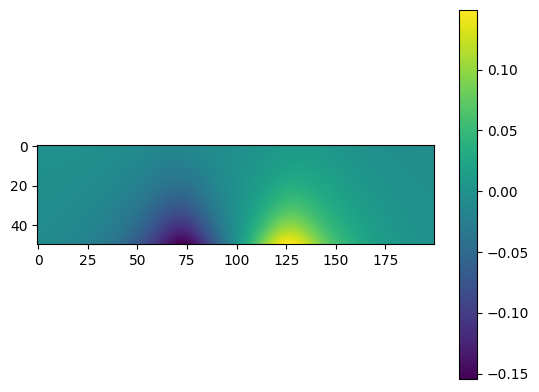

In [9]:
fig,ax = plt.subplots()
im = ax.imshow(uvwp[:,1].reshape(50,200)/1000)
fig.colorbar(im)

Text(0, 0.5, '$y$ (mm)')

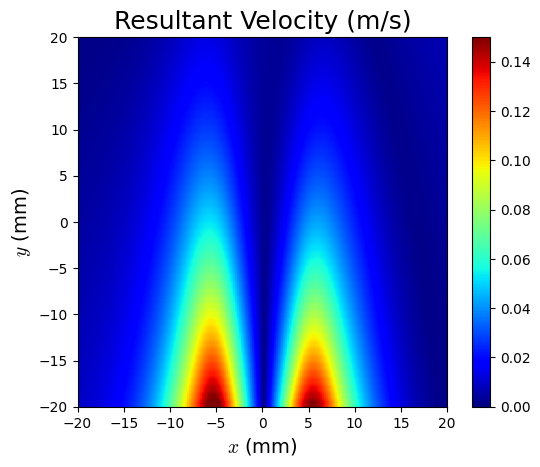

In [10]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((r_vel/1000).reshape(50,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 0.15,vmin = 0)
fig.colorbar(im)
ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_xy_Proposal.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

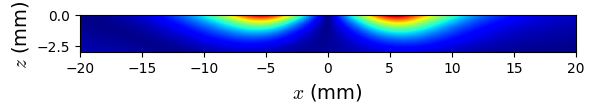

In [11]:
#Cross Section
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((np.flip(r_vel/1000)).reshape(50,200),cmap = 'jet',extent = [-20,20,-3,0],vmax = 0.15,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_xz_Proposal.svg',format = 'svg',bbox_inches = 'tight')

In [12]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2) + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)


eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()


In [13]:
torch.max(T)

tensor(141.9767, grad_fn=<MaxBackward1>)

Text(0, 0.5, '$y$ (mm)')

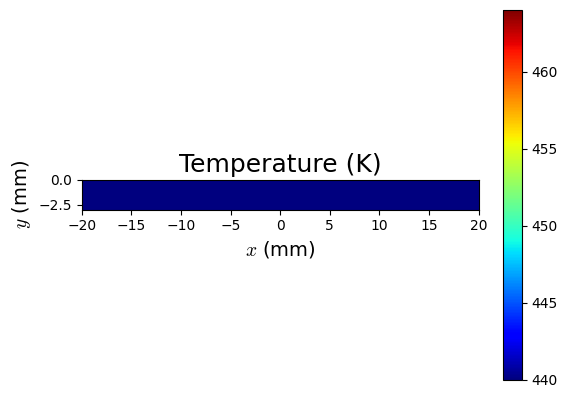

In [14]:
fig,ax = plt.subplots()
im = ax.imshow(T.cpu().detach().numpy().reshape(50,200),cmap = 'jet',extent = [-20,20,-3,0],vmax = 464,vmin = 440)
fig.colorbar(im)
ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Temp_xy_Proposal.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

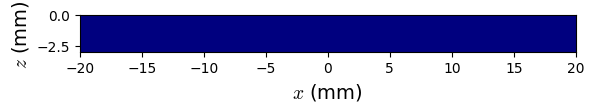

In [15]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(T.cpu().detach().numpy().reshape(50,200)),cmap = 'jet',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Temp_xz_Proposal.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$y$ (mm)')

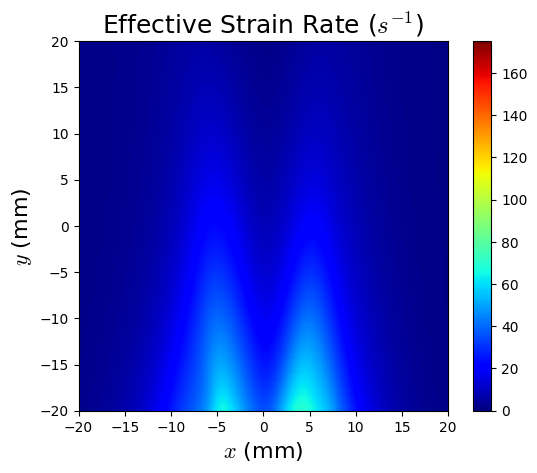

In [16]:
fig,ax = plt.subplots()
im = ax.imshow(eps_e.reshape(50,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 175,vmin = 0)
fig.colorbar(im)
ax.set_title('Effective Strain Rate ($s^{-1}$)',math_fontfamily = 'cm',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 16)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 16)
# plt.savefig('Viscosity_Feb7.svg',format = 'svg',bbox_inches = 'tight')
# plt.savefig('Strain_Rate_xy_Proposal.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

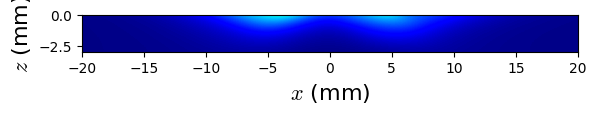

In [17]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(eps_e.reshape(50,200)),cmap = 'jet',extent = [-20,20,-3,0],vmax = 175,vmin = 0)
# fig.colorbar(im)
# ax.set_title('$\dot\epsilon_e$ ($s^{-1}$)',math_fontfamily = 'cm',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 16)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 16)
# plt.savefig('Viscosity_Feb7.svg',format = 'svg',bbox_inches = 'tight')
# plt.savefig('Strain_Rate_xz_Proposal.svg',format = 'svg',bbox_inches = 'tight')

In [18]:
np.min(eps_e)

1.2013394

In [19]:
#Testing with FVM data
fvm_data = loadmat('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/Data/AFSD_Nikhil/Exponential_300_2mms.mat')

u_fvm = fvm_data['u_star']
v_fvm = fvm_data['v_star']
w_fvm = fvm_data['w_star']

u_fvm = (u_fvm[0:-1,:,:] + u_fvm[1:,:,:])/2
v_fvm = (v_fvm[:,0:-1,:] + v_fvm[:,1:,:])/2
w_fvm = (w_fvm[:,:,0:-1] + w_fvm[:,:,1:])/2


Res_v_fvm = np.sqrt(np.square(u_fvm) + np.square(v_fvm) + np.square(w_fvm))
T_fvm = fvm_data['T']
sigma_e_fvm = fvm_data['effectivestress']

/home/smartlab/anaconda3/envs/raghav/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [20]:
fvm_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ABC', 'ALPHA', 'Db', 'De', 'Dn', 'Ds', 'Dt', 'Dw', 'Dx', 'Dy', 'Dz', 'FL', 'Fb', 'Fe', 'Fn', 'Fs', 'Ft', 'Fw', 'None', 'Lx', 'Ly', 'Lz', 'N', 'Nx', 'Ny', 'Nz', 'RPS', 'SZ', 'T', 'Tb', 'Te', 'Theat', 'Tn', 'Told', 'Ts', 'Tt', 'Tw', 'X', 'Xcenter', 'Y', 'Ycenter', 'Z', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'aB', 'aE', 'aN', 'aP', 'aS', 'aT', 'aW', 'alpha', 'alpha4', 'alpha5', 'alpha6', 'alphaP', 'alphaU', 'ans', 'b1', 'b2', 'ba', 'c', 'c1', 'c2', 'c3', 'd_u', 'd_v', 'd_w', 'delta', 'delta1', 'dx', 'dy', 'dz', 'eexx', 'eeyy', 'eezz', 'effectivestress', 'effstrrate', 'ep', 'ep1', 'errorheat', 'errormax', 'exp1', 'hbo', 'heat', 'hup', 'i', 'imax', 'ite', 'itera', 'iteration', 'j', 'jmax', 'k', 'k1', 'k2', 'k3', 'kmax', 'ku', 'l', 'maxRes', 'maxRes_u', 'maxRes_v', 'maxRes_w', 'mu', 'mumax', 'p', 'pB', 'pE', 'pN', 'pP', 'pRes', 'pS', 'pT', 'pW', 'p_prime', 'p_star', 'plasticheat', 'pold', 'pressure_term', 'q', 'q1', 'q2', 'q3', 'qu', 'ro',

In [21]:
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

# x_min = -20.0
# x_max = 20.0

# x = np.linspace(x_min,x_max,250)
x = np.linspace(x_min,x_max,251)
x = (x[0:-1] + x[1:]).reshape(-1,1)/2
y = np.linspace(y_min,y_max,101)
y = (y[0:-1] + y[1:]).reshape(-1,1)/2
z = np.linspace(z_min,z_max,13)
z = (z[0:-1] + z[1:]).reshape(-1,1)/2

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()

Res_v_PINN = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2])).reshape(12,250,100,order = 'C')

Res_v_PINN = np.swapaxes(np.swapaxes(Res_v_PINN,0,1),1,2)/1000

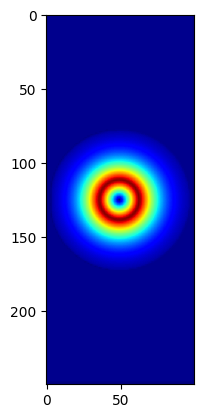

In [22]:
plt.imshow(Res_v_fvm[:,:,11],cmap = 'jet')

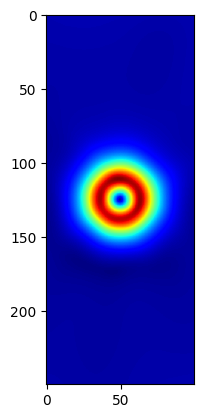

In [23]:
plt.imshow(Res_v_PINN[:,:,11],cmap = 'jet')

In [24]:
RE = np.linalg.norm((Res_v_PINN-Res_v_fvm).reshape(-1,),2)/np.linalg.norm(Res_v_fvm.reshape(-1,),2)
print(RE)

0.44109598388079


In [25]:
RMSE = np.sqrt(np.mean(np.square(Res_v_fvm[:]-Res_v_PINN[:])))
print(RMSE)

0.0056291122974841176


In [26]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)


eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()


In [27]:
T_PINN = T.cpu().detach().numpy().reshape(12,250,100,order = 'C')
T_PINN = np.swapaxes(np.swapaxes(T_PINN,0,1),1,2)

print("RE: ",np.linalg.norm((T_PINN-T_fvm).reshape(-1,),2)/np.linalg.norm(T_fvm.reshape(-1,),2))
print("RMSE: ",np.sqrt(np.mean(np.square(T_fvm[:]-T_PINN[:]))))

RE:  0.9885722736382235
RMSE:  534.5466188180594


In [28]:
#Correlation between Predicted and Actual 
np.corrcoef(T_PINN.reshape(-1,),T_fvm.reshape(-1,))

array([[ 1.        , -0.70145009],
       [-0.70145009,  1.        ]])

In [29]:
np.corrcoef(Res_v_PINN.reshape(-1,),Res_v_fvm.reshape(-1,))

array([[1.        , 0.96236618],
       [0.96236618, 1.        ]])

In [30]:
eps_e = eps_e.reshape(12,250,100,order = 'C')
eps_e = np.swapaxes(np.swapaxes(eps_e,0,1),1,2)

eps_e_fvm = fvm_data['effstrrate']
np.corrcoef(eps_e.reshape(-1,),eps_e_fvm.reshape(-1,))

array([[1.        , 0.96278737],
       [0.96278737, 1.        ]])

In [31]:
print("RE: ",np.linalg.norm((eps_e-eps_e_fvm).reshape(-1,),2)/np.linalg.norm(eps_e_fvm.reshape(-1,),2))
print("RMSE: ",np.sqrt(np.mean(np.square(eps_e_fvm[:]-eps_e[:]))))

RE:  0.4822057595712392
RMSE:  2.794877998713986
